In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv




## 1.1 Loading of Libraries
### Load all the libraries to be used

In [2]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode(connected = True)

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
from fbprophet import Prophet


## 1.2 Loading of Datasets
### Let us load the datasets

In [3]:
path = '/kaggle/input/store-sales-time-series-forecasting/'
oil_data = pd.read_csv(path+'oil.csv')
train = pd.read_csv(path+'train.csv', parse_dates = True, low_memory = False, index_col = 'date')
test = pd.read_csv(path+'test.csv')
submission_sample = pd.read_csv(path+'sample_submission.csv')
holidays_data = pd.read_csv(path+'holidays_events.csv')
store_data =  pd.read_csv(path+'stores.csv')
transaction_data = pd.read_csv(path+'transactions.csv')


# time series as indexes
train.index

DatetimeIndex(['2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01',
               ...
               '2017-08-15', '2017-08-15', '2017-08-15', '2017-08-15',
               '2017-08-15', '2017-08-15', '2017-08-15', '2017-08-15',
               '2017-08-15', '2017-08-15'],
              dtype='datetime64[ns]', name='date', length=3000888, freq=None)

[back to top](#table-of-contents)
<a id="2"></a>
# 2. Data Exploration
Let us explore the data 

[back to top](#table-of-contents)
<a id="2.1"></a>
## 2.1 Number of Roww and Columns. 
### Let us load the datasets. Check the shape and info about the datasets

In [4]:
print('Number of train samples: ', train.shape)
print('Number of test samples: ', test.shape)
print('Number of store data: ', store_data.shape)
print('Number of Holiday data: ', holidays_data.shape)
print('Number of Oil Price data: ', oil_data.shape)
print('Number of features: ', len(train.columns))
print(train.info())
print(train.columns)

Number of train samples:  (3000888, 5)
Number of test samples:  (28512, 5)
Number of store data:  (54, 5)
Number of Holiday data:  (350, 6)
Number of Oil Price data:  (1218, 2)
Number of features:  5
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 137.4+ MB
None
Index(['id', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')


In [5]:
train.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


[back to top](#table-of-contents)
<a id="2.2"></a>
## 2.2 Further exploration

## Short description of Key Fields
* date: Date of entry
* store_nbr: Store Number
* sales: the turnover for any given day (target variable).
* family: Product Family
* store_type: Type of Store
* cluster: Store Cluster
* city: City
* state: State the store is located in
* onpromotion: indicates whether a store is running a promo on that day.
* holiday_type & locale : If it was a holiday and type of holiday
* transactions: Number of transactions
* sales: sales volume

In [6]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 137.4+ MB


id             0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

### Generate Year, Month, Day and Week of the Year Categorical fields

In [7]:
# data extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear



### Merge the Training data with Store Data for an expanded view

In [8]:
train_store=train.merge(store_data, on = 'store_nbr', how='left')
train_store.head()

,id,store_nbr,family,sales,onpromotion,Year,Month,Day,WeekOfYear,city,state,type,cluster
0,0,1,AUTOMOTIVE,0.0,0,2013,1,1,1,Quito,Pichincha,D,13
1,1,1,BABY CARE,0.0,0,2013,1,1,1,Quito,Pichincha,D,13
2,2,1,BEAUTY,0.0,0,2013,1,1,1,Quito,Pichincha,D,13
3,3,1,BEVERAGES,0.0,0,2013,1,1,1,Quito,Pichincha,D,13
4,4,1,BOOKS,0.0,0,2013,1,1,1,Quito,Pichincha,D,13


### Check for Unique Values

In [9]:
ts_unique = train_store.nunique()
for index, value in ts_unique.items():
    print(f"Index : {index}, Value : {value}")
    if value < 50:
        print('*'*50)
        print('keys')
        print('*'*50)
        print(train_store[index].unique())
    else:
        print('*'*50)
        print('skipping', index)
        print('More than 50 unique elements')
        print('*'*50)
        

Index : id, Value : 3000888
**************************************************
skipping id
More than 50 unique elements
**************************************************
Index : store_nbr, Value : 54
**************************************************
skipping store_nbr
More than 50 unique elements
**************************************************
Index : family, Value : 33
**************************************************
keys
**************************************************
['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']
Index : sales, Value : 379610
***********************

[back to top](#table-of-contents)
<a id="3"></a>
# 3. Features Analysis

### Let us see some graphs

#### Family , Cluster, Type, State, City and Date elements with less than 50 unique values

In [10]:
import matplotlib.pyplot as plt
import random
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def random_color():
    return "#{}{}{}{}{}{}".format(*(random.choice("0123456789abcdef") for _ in range(6)))

# Data preparation
ts_sales_type = train_store.groupby('type').agg({"sales": "mean"}).reset_index().sort_values(by='sales', ascending=False)
ts_sales_family = train_store.groupby('family').agg({"sales": "mean"}).reset_index().sort_values(by='sales', ascending=False)[:20]
ts_sales_cluster = train_store.groupby('cluster').agg({"sales": "mean"}).reset_index().sort_values(by='sales', ascending=False)
ts_sales_state = train_store.groupby('state').agg({"sales": "mean"}).reset_index().sort_values(by='sales', ascending=False)
ts_sales_city = train_store.groupby('city').agg({"sales": "mean"}).reset_index().sort_values(by='sales', ascending=False)

# Assign random colors
ts_sales_type['color'] = [random_color() for _ in range(len(ts_sales_type))]
ts_sales_family['color'] = [random_color() for _ in range(len(ts_sales_family))]
ts_sales_cluster['color'] = [random_color() for _ in range(len(ts_sales_cluster))]
ts_sales_state['color'] = [random_color() for _ in range(len(ts_sales_state))]
ts_sales_city['color'] = [random_color() for _ in range(len(ts_sales_city))]

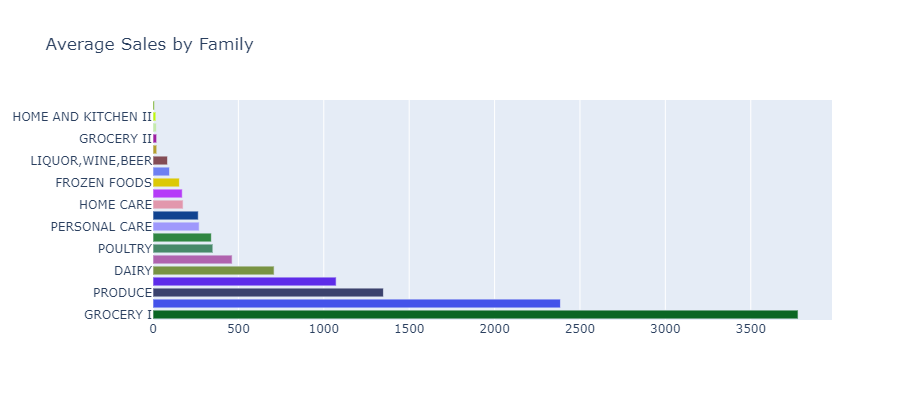

In [11]:
# Figure 1: Bar chart for Average Sales by Family
fig_family = go.Figure()
fig_family.add_trace(go.Bar(x=ts_sales_family['sales'], 
                             y=ts_sales_family['family'],
                             marker=dict(color=ts_sales_family['color']),
                             name='Family', orientation='h'))
fig_family.update_layout(title='Average Sales by Family', height=400)
fig_family.show()

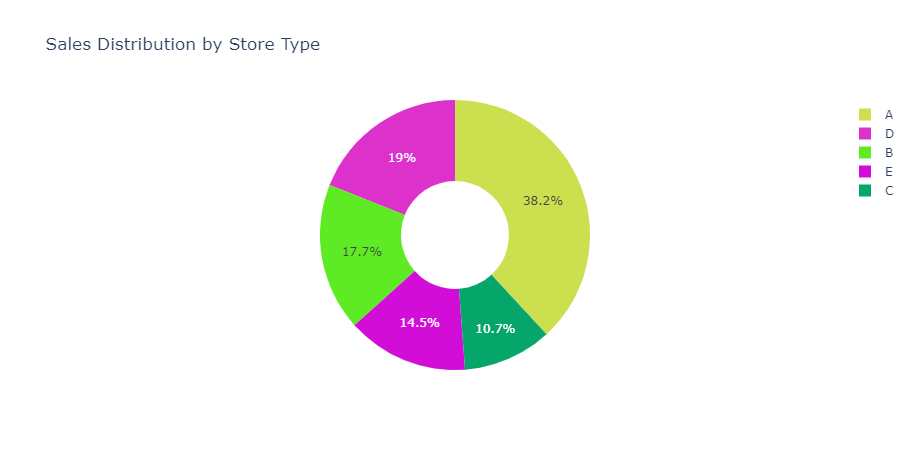

In [12]:
# Figure 2: Pie chart for Store Type
fig_type = go.Figure()
fig_type.add_trace(go.Pie(values=ts_sales_type['sales'], 
                           labels=ts_sales_type['type'], 
                           name='Store Type',
                           marker=dict(colors=ts_sales_type['color']),
                           hole=0.4))
fig_type.update_layout(title='Sales Distribution by Store Type')
fig_type.show()

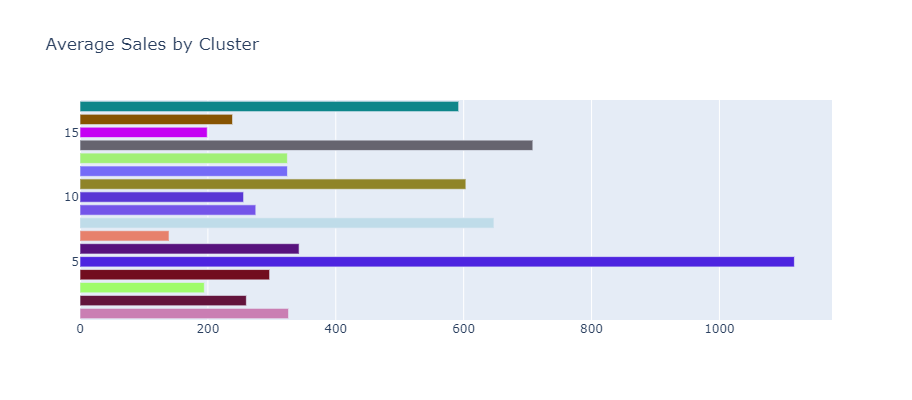

In [13]:
# Figure 3: Bar chart for Average Sales by Cluster
fig_cluster = go.Figure()
fig_cluster.add_trace(go.Bar(x=ts_sales_cluster['sales'], 
                              y=ts_sales_cluster['cluster'],
                              marker=dict(color=ts_sales_cluster['color']),
                              name='Cluster', orientation='h'))
fig_cluster.update_layout(title='Average Sales by Cluster', height=400)
fig_cluster.show()


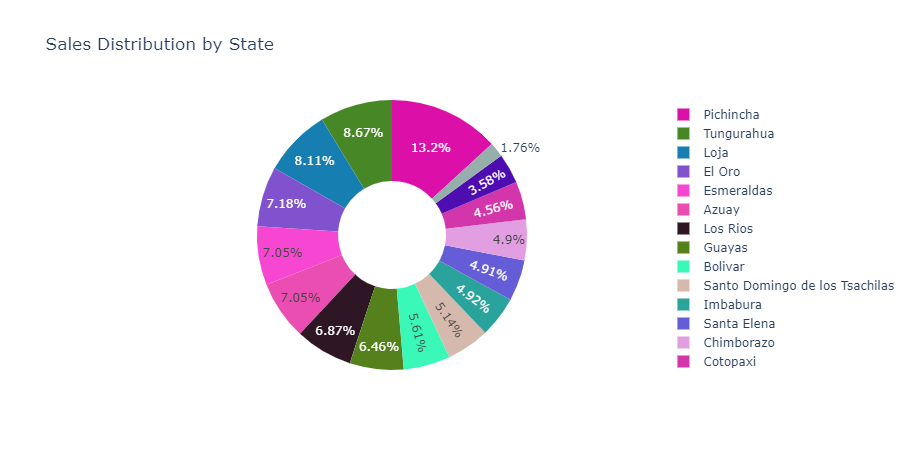

In [14]:
# Figure 4: Pie chart for Average Sales by State
fig_state = go.Figure()
fig_state.add_trace(go.Pie(values=ts_sales_state['sales'], 
                            labels=ts_sales_state['state'], 
                            name='State',
                            marker=dict(colors=ts_sales_state['color']),
                            hole=0.4))
fig_state.update_layout(title='Sales Distribution by State')
fig_state.show()

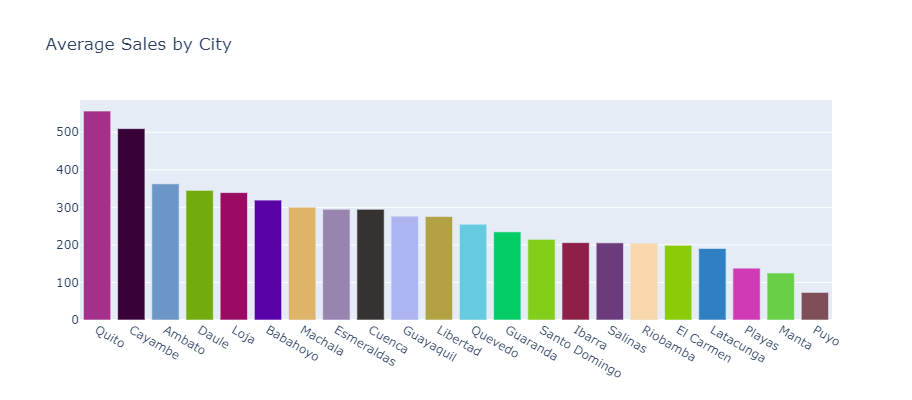

In [15]:
# Figure 5: Bar chart for Average Sales by City
fig_city = go.Figure()
fig_city.add_trace(go.Bar(x=ts_sales_city['city'], 
                           y=ts_sales_city['sales'], 
                           marker=dict(color=ts_sales_city['color']), 
                           name='City'))
fig_city.update_layout(title='Average Sales by City', height=400)
fig_city.show()

## Let us explore some ECDF and statistical graphs

Text(0.5, 0, 'Promotions')

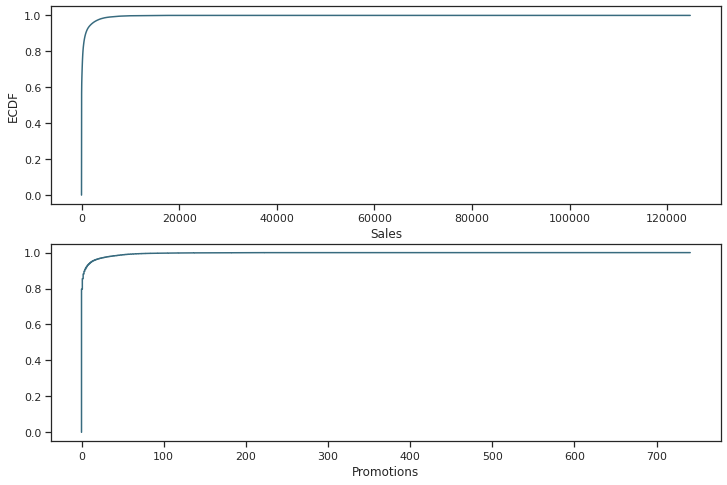

In [16]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 8))

plt.subplot(211)
cdf = ECDF(train['sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c)
plt.xlabel('Sales')
plt.ylabel('ECDF')

# plot second ECDF  
plt.subplot(212)
cdf = ECDF(train['onpromotion'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c)
plt.xlabel('Promotions')



## Let us check the content for the store_data including sum of null values

In [17]:
store_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [18]:
store_data.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

## Let us ejoin store data with stores by number

In [19]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store_data, how = 'inner', on = 'store_nbr')

print("In total: ", train_store.shape)
train_store.head()

Joining train set with an additional store information.
In total:  (3000888, 13)


,id,store_nbr,family,sales,onpromotion,Year,Month,Day,WeekOfYear,city,state,type,cluster
0,0,1,AUTOMOTIVE,0.0,0,2013,1,1,1,Quito,Pichincha,D,13
1,1,1,BABY CARE,0.0,0,2013,1,1,1,Quito,Pichincha,D,13
2,2,1,BEAUTY,0.0,0,2013,1,1,1,Quito,Pichincha,D,13
3,3,1,BEVERAGES,0.0,0,2013,1,1,1,Quito,Pichincha,D,13
4,4,1,BOOKS,0.0,0,2013,1,1,1,Quito,Pichincha,D,13


## Plot a Barplot on Sales and Family columns

<AxesSubplot:xlabel='sales', ylabel='family'>

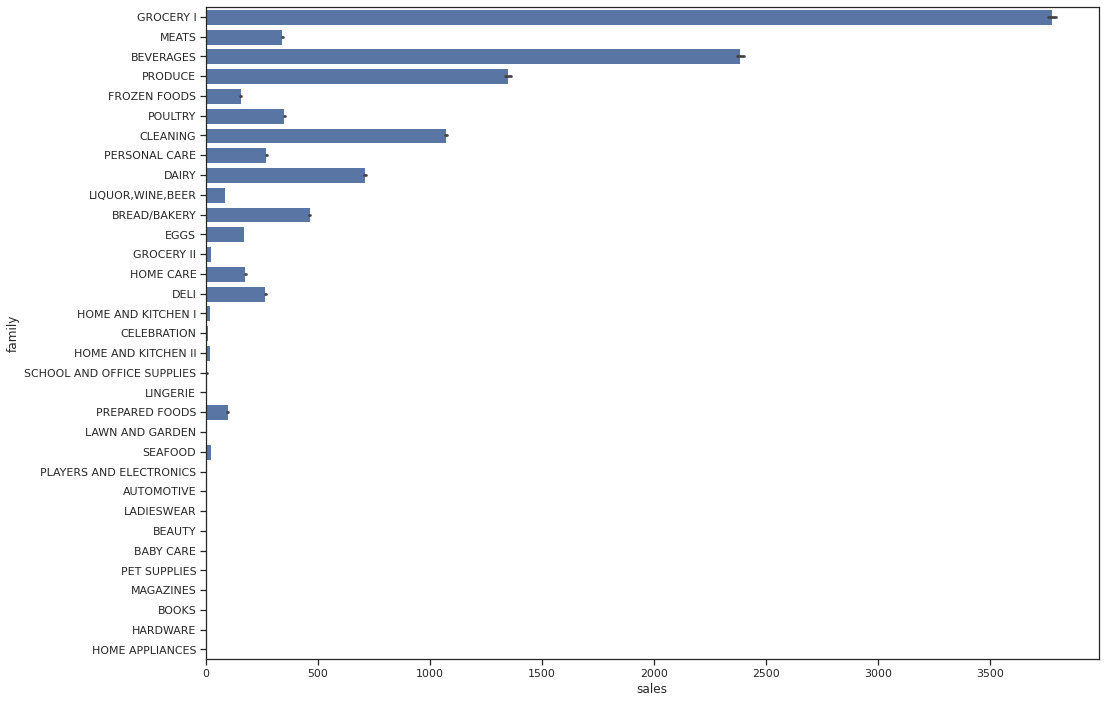

In [20]:
plt.figure(figsize=(16,12))
sns.barplot(x="sales", y="family", data=train_store.sort_values(by=['sales','family'], ascending=False),
            label="Sales", color="b")

## Plot a Seaborn Relplot 

<Figure size 1728x1296 with 0 Axes>

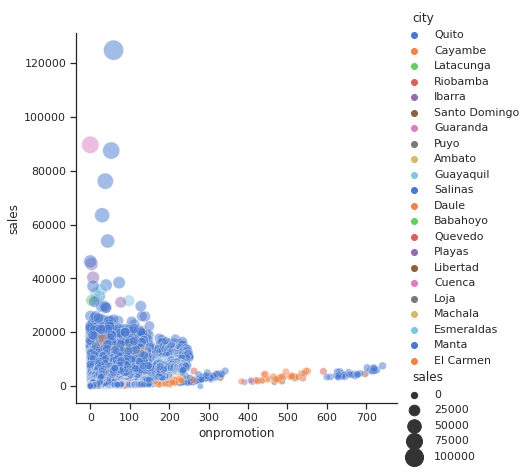

In [21]:
plt.figure(figsize=(24,18))
sns.relplot(x="onpromotion", y="sales", hue="city", size="sales",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=train_store)

## Some EDA on Holidays

<AxesSubplot:title={'center':'Counts of type of holiday'}, xlabel='locale', ylabel='count'>

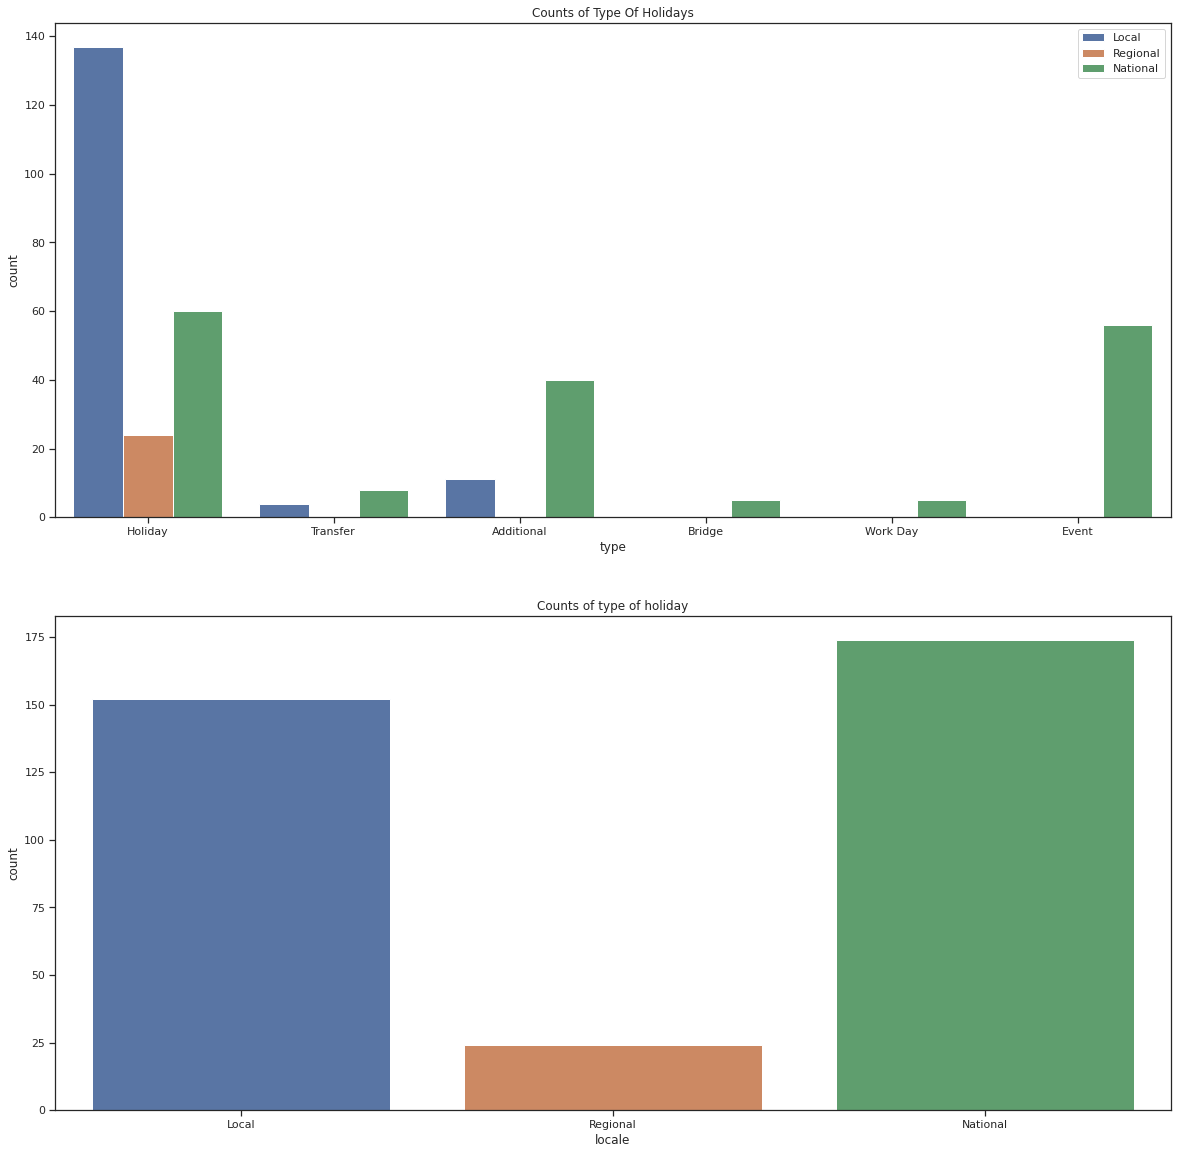

In [22]:
plt.subplots(1,2,figsize=(20,20))
plt.subplot(211)
plt.title('Counts of Type Of Holidays')
sns.countplot(x=holidays_data.type, hue=holidays_data.locale)
plt.legend(loc='upper right')
plt.subplot(212)
plt.title('Counts of type of holiday')
sns.countplot(x=holidays_data.locale)

### Plot a relplot on City , Sales and Family with a hue on State

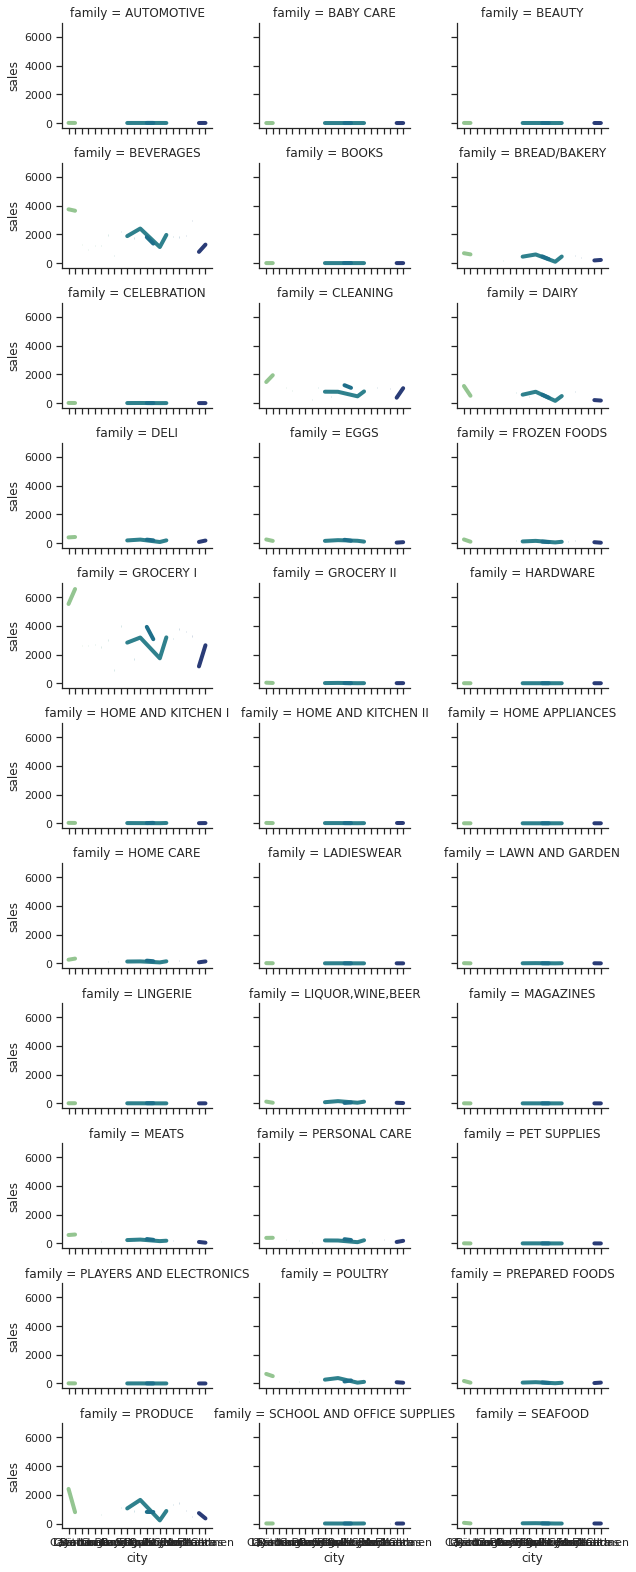

In [23]:
g = sns.relplot(
    data=train_store,
    x="city", y="sales", col="family", hue="state",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)

## Some Store Data EDA

<AxesSubplot:xlabel='count', ylabel='city'>

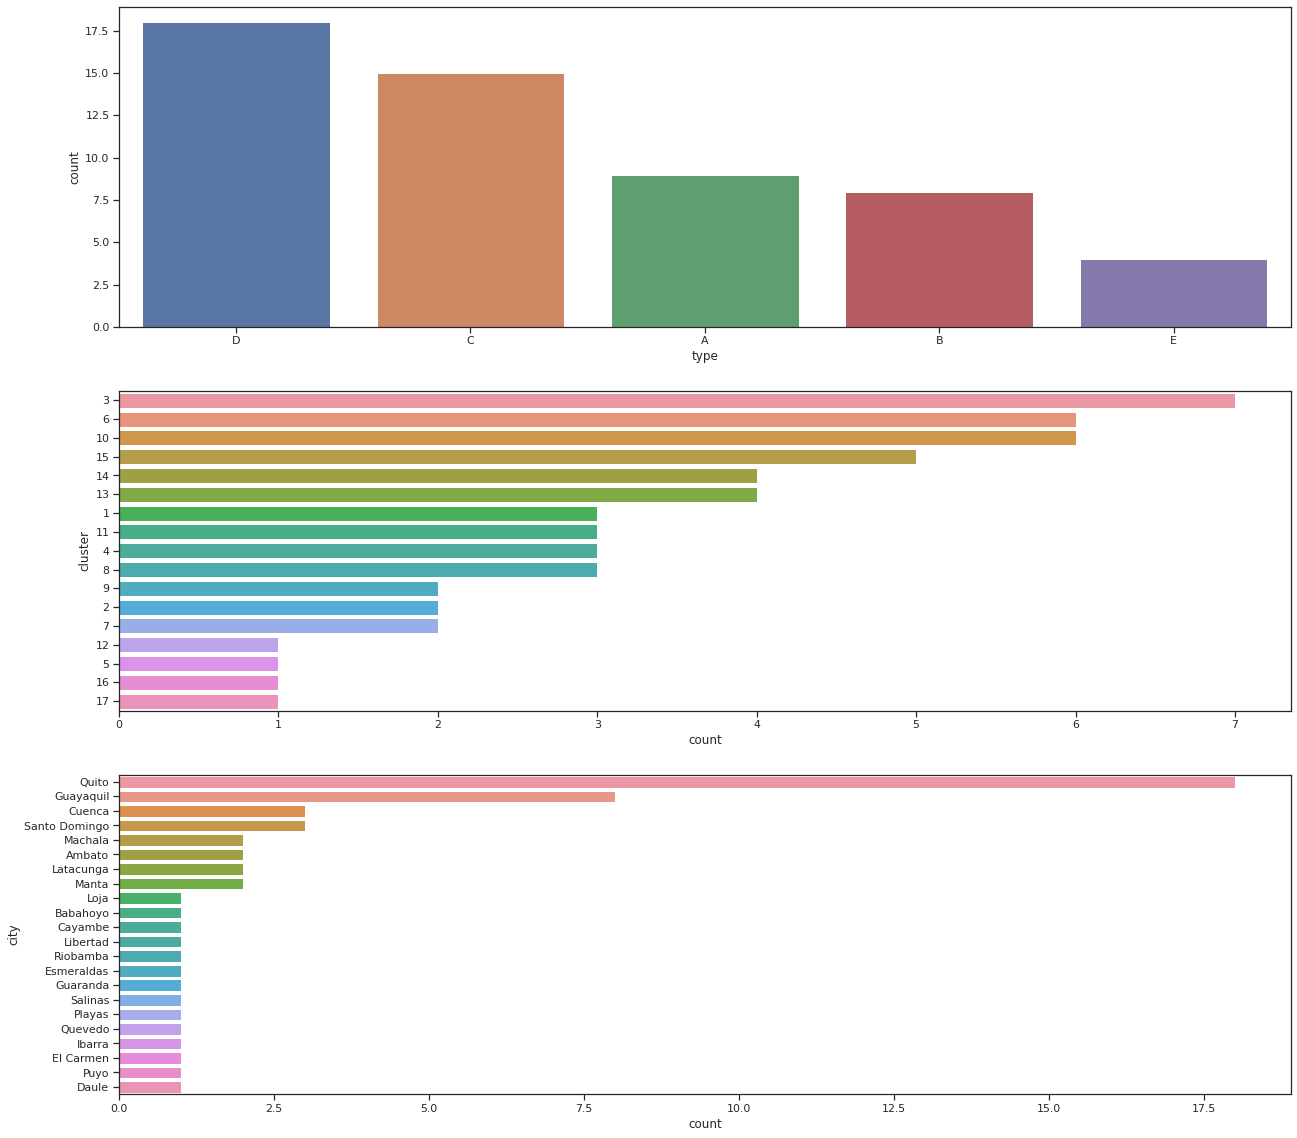

In [24]:
plt.subplots(1,3,figsize=(21,20))
plt.subplot(311)
sns.countplot(x=store_data.type, order = store_data.type.value_counts().index)
plt.subplot(312)
sns.countplot(y=store_data.cluster, order = store_data.cluster.value_counts().index)
plt.subplot(313)
sns.countplot(y=store_data.city, order = store_data.city.value_counts().index)

### Plot a factorplot on yearly sales by cluster and type of store

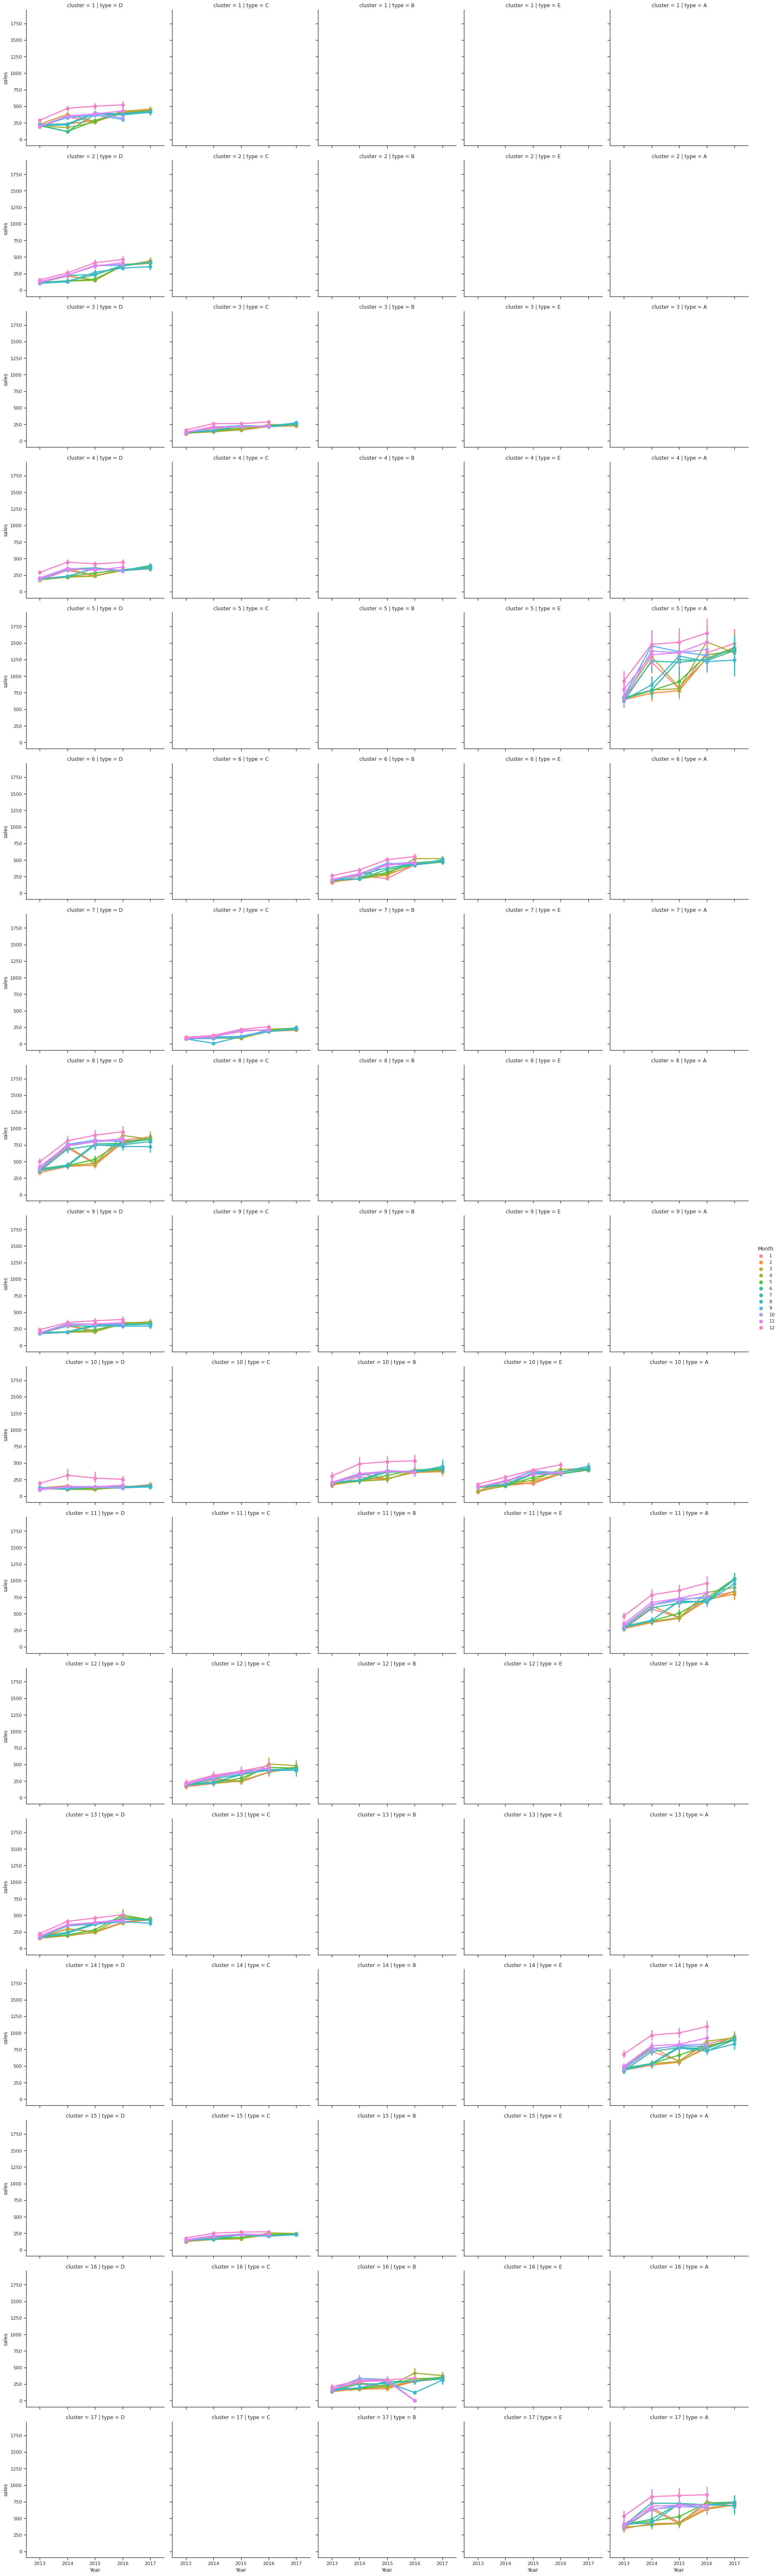

In [25]:
sns.factorplot(data = train_store, x ="Year", y = "sales", 
               col = 'type', # per store type in cols
               hue = 'Month',
               row = "cluster")

### Plot a Category Plot on Type and Cluster - Use Strip Plot

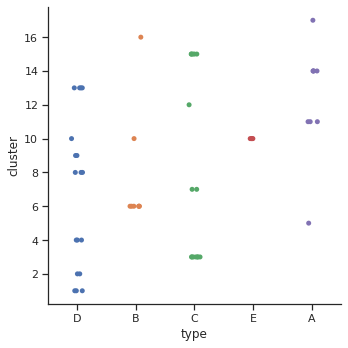

In [26]:
sns.catplot(x = 'type', y='cluster',data=store_data, kind='strip')

### Plot a Category Plot on Type and Cluster - Use Swarm  Plot

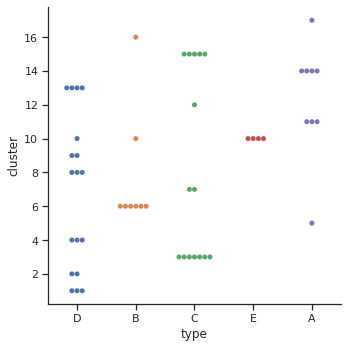

In [27]:
sns.catplot(x = 'type', y='cluster',data=store_data, kind='swarm')

## Let us group by state the store city, type of store and sales summary is 

In [28]:

train_store.groupby('state')['city','type','sales'].sum()


,sales
state,
Azuay,4.916860e+07
Bolivar,1.304951e+07
Chimborazo,1.138792e+07
Cotopaxi,2.118226e+07
El Oro,3.338680e+07
Esmeraldas,1.639169e+07
Guayas,1.651544e+08
Imbabura,1.145127e+07
Loja,1.886000e+07


## Let us group by city the store by state, type of store and sales summary 

In [29]:
train_store.groupby('city')['state','type','sales'].sum()

,sales
city,
Ambato,4.030440e+07
Babahoyo,1.774687e+07
Cayambe,2.832556e+07
Cuenca,4.916860e+07
Daule,1.918802e+07
El Carmen,1.105748e+07
Esmeraldas,1.639169e+07
Guaranda,1.304951e+07
Guayaquil,1.229673e+08


### Plot Barchart on Store Sales by Store and Sales Value

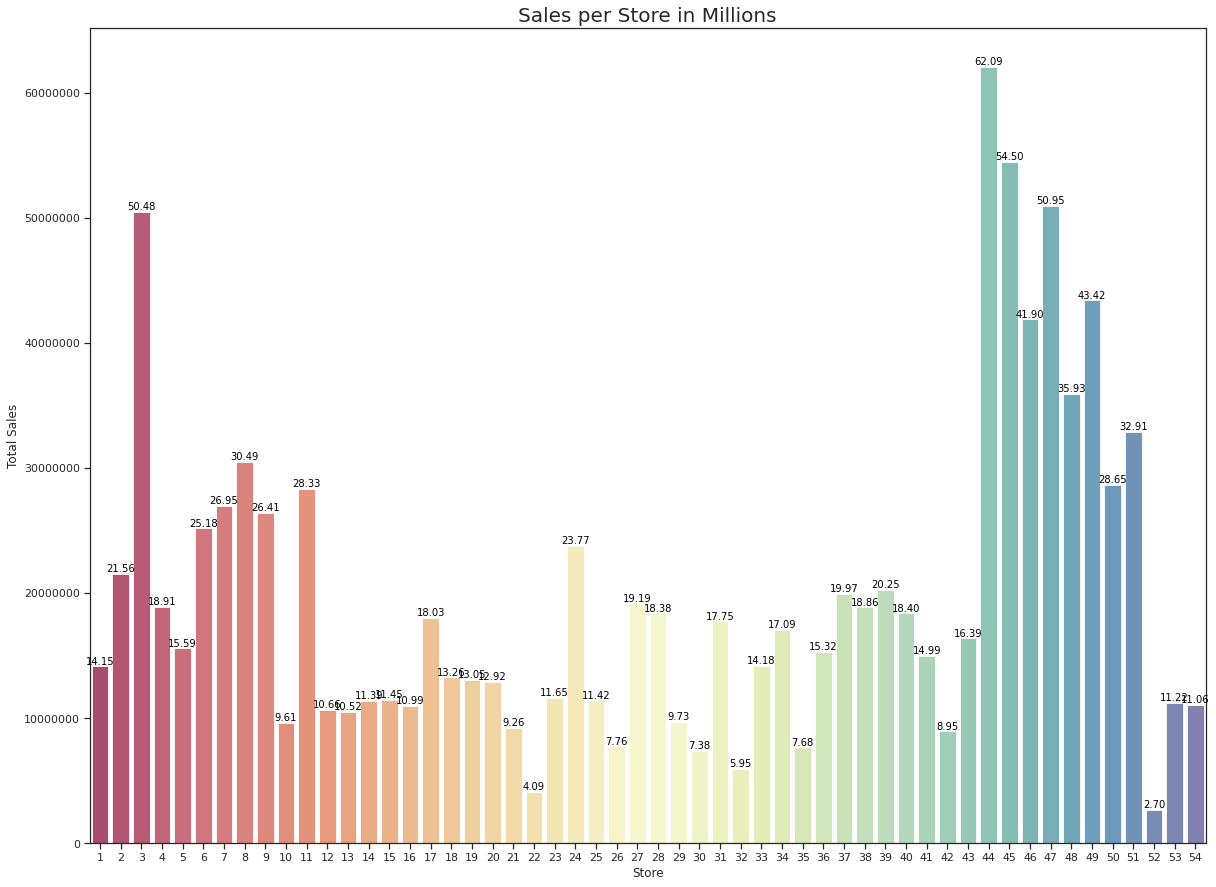

In [30]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
x=train_store.groupby('store_nbr')['city','type','sales'].sum()
x=x.sort_values(by='sales',ascending=False)
x=x.iloc[0:55].reset_index()

plt.figure(figsize=(20,15))
ax= sns.barplot( x.store_nbr ,x.sales, alpha=0.8,  palette="Spectral")
# annotation here
for p in ax.patches:
    ax.annotate("%.2f" % round((p.get_height()/1000000),2), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')


plt.ticklabel_format(style='plain', axis='y')
plt.title("Sales per Store in Millions", fontsize=20)
plt.ylabel('Total Sales', fontsize=12)
plt.xlabel('Store', fontsize=12)
plt.show()


### Plot Barchart on Store Sales by City and Sales Value

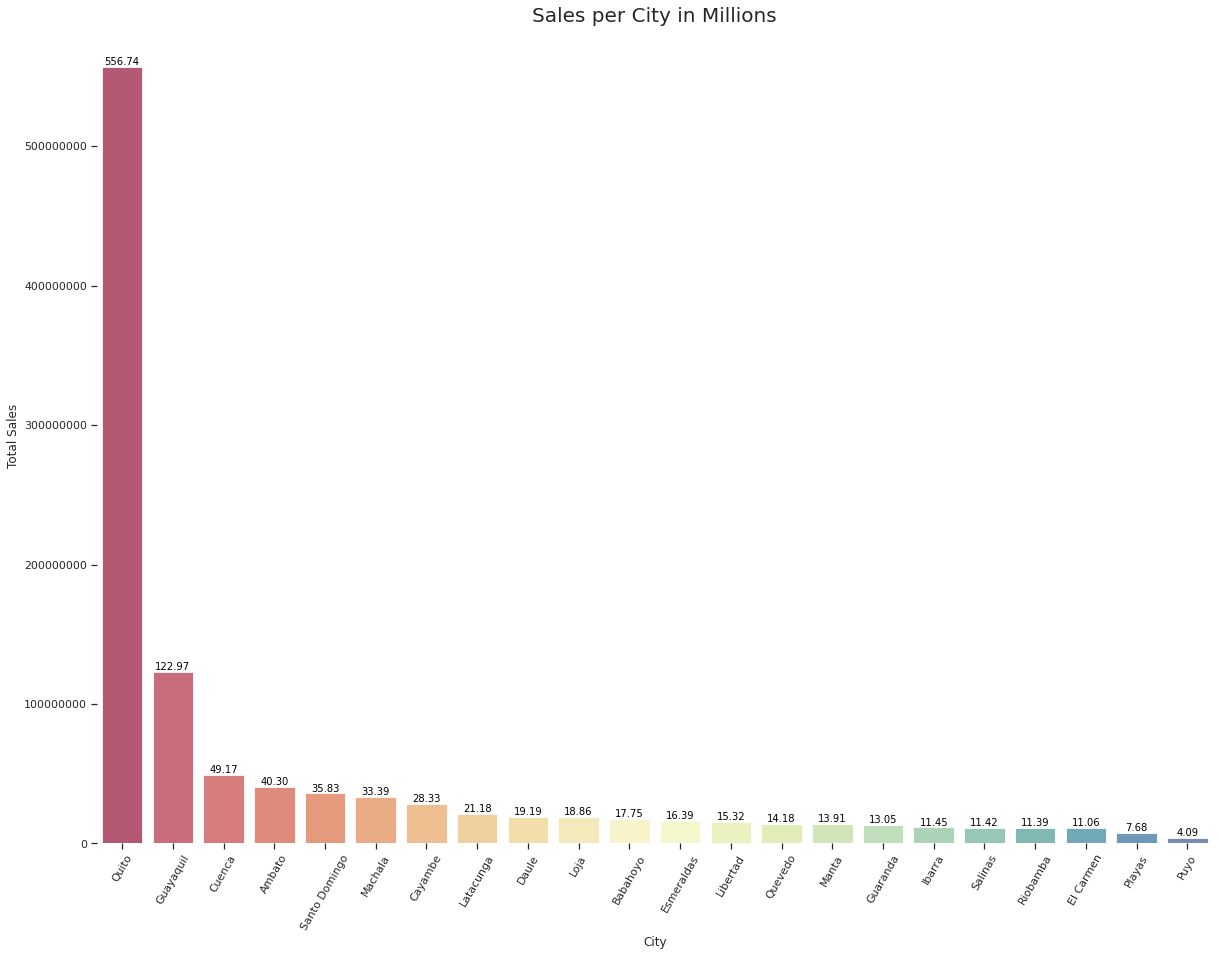

In [31]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
x=train_store.groupby('city')['store_nbr','type','sales'].sum()
x=x.sort_values(by='sales',ascending=False)
x=x.iloc[0:55].reset_index()

plt.figure(figsize=(20,15))
ax= sns.barplot( x.city ,x.sales, alpha=0.8,  palette="Spectral")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
# annotation here
for p in ax.patches:
    ax.annotate("%.2f" % round((p.get_height()/1000000),2), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')


plt.ticklabel_format(style='plain', axis='y')
plt.title("Sales per City in Millions", fontsize=20)
plt.ylabel('Total Sales', fontsize=12)
plt.xlabel('City', fontsize=12)
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=60)
sns.despine(left=True, bottom=True)
plt.show()


### Plot Barchart on Store Sales by State and Sales Value

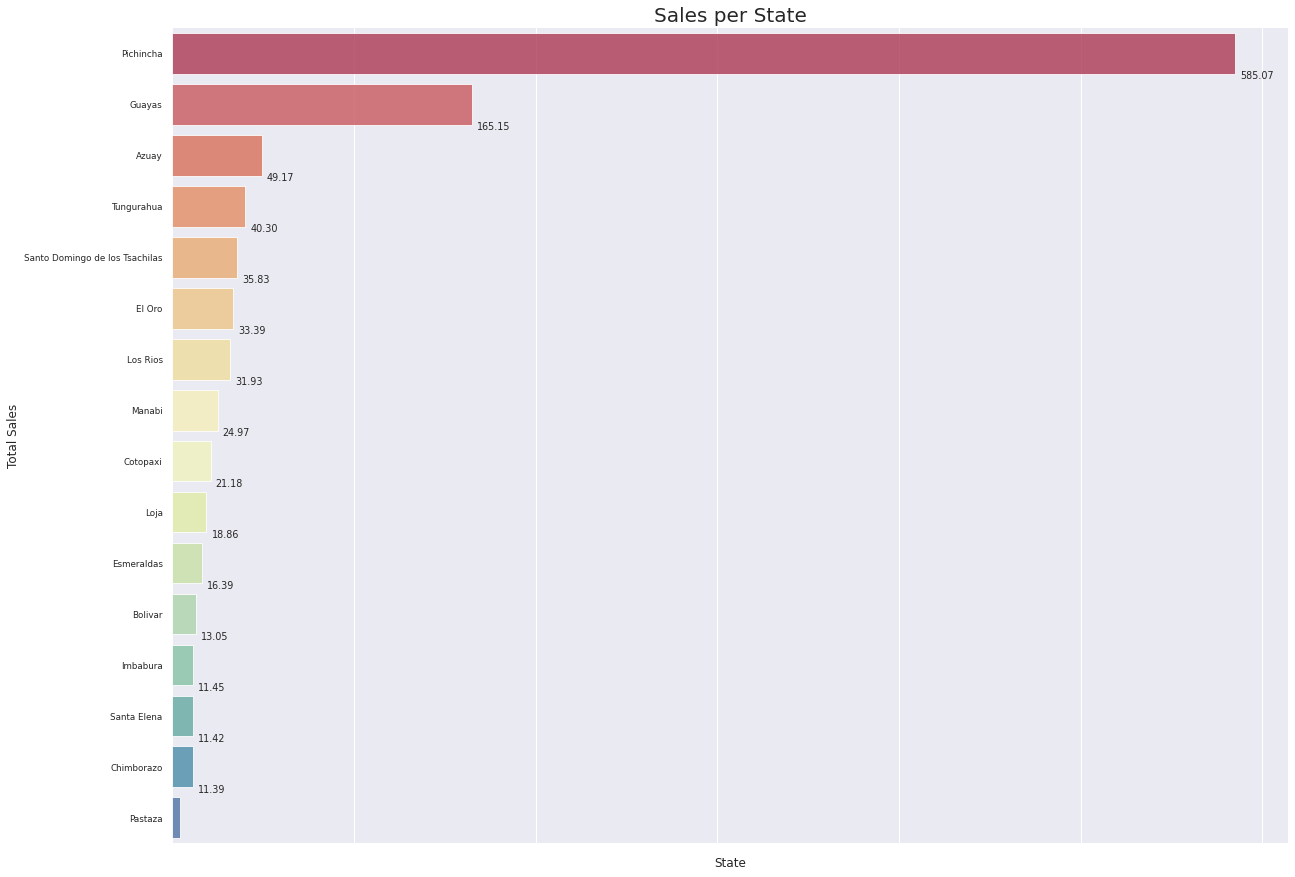

In [32]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
sns.set(font_scale=0.8)
x=train_store.groupby('state')['store_nbr','type','sales'].sum()
x=x.sort_values(by='sales',ascending=False)
x=x.iloc[0:55].reset_index()

plt.figure(figsize=(20,15))
ax= sns.barplot( x.sales ,x.state, alpha=0.8,  palette="Spectral")

for p in ax.patches:
    ax.annotate("%.2f" % round((p.get_width()/1000000),2), (p.get_x() + p.get_width(), p.get_y() + 1.2),
                xytext=(5, 15), textcoords='offset points')

sns.set(font_scale=0.8)
plt.title("Sales per State", fontsize=20)
plt.ylabel('Total Sales', fontsize=12)
plt.xlabel('State', fontsize=12)
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=60)
sns.despine(left=True, bottom=True)
sns.set_style('whitegrid')
plt.show()

### Build Submission Sample Data

In [33]:
# importing data
train = pd.read_csv(path+'train.csv', parse_dates = True, low_memory = False, index_col = 'date')
test = pd.read_csv(path+'test.csv')
submission_sample = pd.read_csv(path+'sample_submission.csv')


## Let us check the training dataset value

In [34]:
train.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


## Reset the index values and take care of date Vs datetime fields

In [35]:
train=train.reset_index()
# sales for the store number 1 (StoreType C)
sales = train[train.store_nbr == 44].loc[:, ['date', 'sales']]

sales = sales.sort_index(ascending = False)

# to datetime64
sales['date'] = pd.DatetimeIndex(sales['date'])
sales.dtypes

# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'date': 'ds',
                                'sales': 'y'})
sales.head()


,ds,y
3000392,2017-08-15,80.240
3000391,2017-08-15,345.000
3000390,2017-08-15,7239.617
3000389,2017-08-15,329.522
3000388,2017-08-15,909.194


## Plot daily sales 

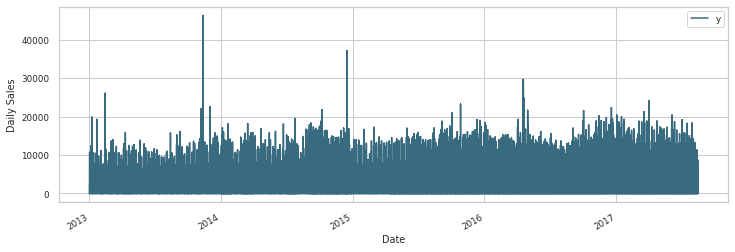

In [36]:

# plot daily sales
ax = sales.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Sales')
ax.set_xlabel('Date')
plt.show()

## Check for holiday types and locale

In [37]:
holidays_data.groupby(['type','locale']).head(100)
print(holidays_data.type.unique())
print(holidays_data.locale.unique())

['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']
['Local' 'Regional' 'National']


## Check for holiday types and and group based on national, state and general holiday types

In [38]:
# create holidays dataframe
state_dates = holidays_data[((holidays_data.locale == 'National') |
                             (holidays_data.locale == 'Regional') &
                             (holidays_data.type == 'Holiday'))].loc[:, 'date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
holidays = state      
holidays.head()

,holiday,ds
0,state_holiday,2012-04-01
1,state_holiday,2012-06-25
2,state_holiday,2012-08-10
3,state_holiday,2012-10-09
4,state_holiday,2012-10-12


## Set parameters for Facebook Prophet model and use it to fit the data

In [39]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
my_model.fit(sales)

# dataframe that extends into future 52 weeks 
future_dates = my_model.make_future_dataframe(periods = 52*7)

print("First week to forecast.")
future_dates.tail(7)

Initial log joint probability = -111.453
First week to forecast.


,ds
2041,2018-08-08
2042,2018-08-09
2043,2018-08-10
2044,2018-08-11
2045,2018-08-12
2046,2018-08-13
2047,2018-08-14


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        130970    0.00399387       1604.89           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        130976    0.00021559       342.138           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        130977     0.0029507       187.645           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        130979   0.000120248       136.157           1           1      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     436        130979   6.12736e-06       150.331   2.357e-08       0.001      575  LS failed, Hessian reset 
     499        130979     0.0027751       458.642           1           1      6

## Predict the values based on the fitted model

In [40]:
# predictions
forecast = my_model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)


,ds,yhat,yhat_lower,yhat_upper
2041,2018-08-08,1353.805363,-3663.208086,6630.728417
2042,2018-08-09,1076.258071,-4157.969619,6748.475560
2043,2018-08-10,1278.912314,-4468.419224,6837.872319
2044,2018-08-11,1699.253671,-3508.491778,6947.153220
2045,2018-08-12,1782.761527,-3427.046725,7196.157188
2046,2018-08-13,1262.264827,-3233.114233,6720.701594
2047,2018-08-14,1177.189896,-4093.688895,6813.844208


## Forecast future values

In [41]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

## Plot the Prophet Forecast model

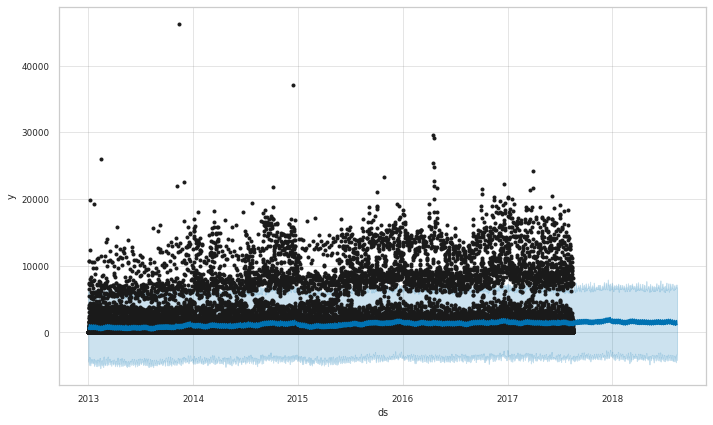

In [42]:
# visualizing predicions
my_model.plot(forecast);

## Plot the Prophet Forecast model components

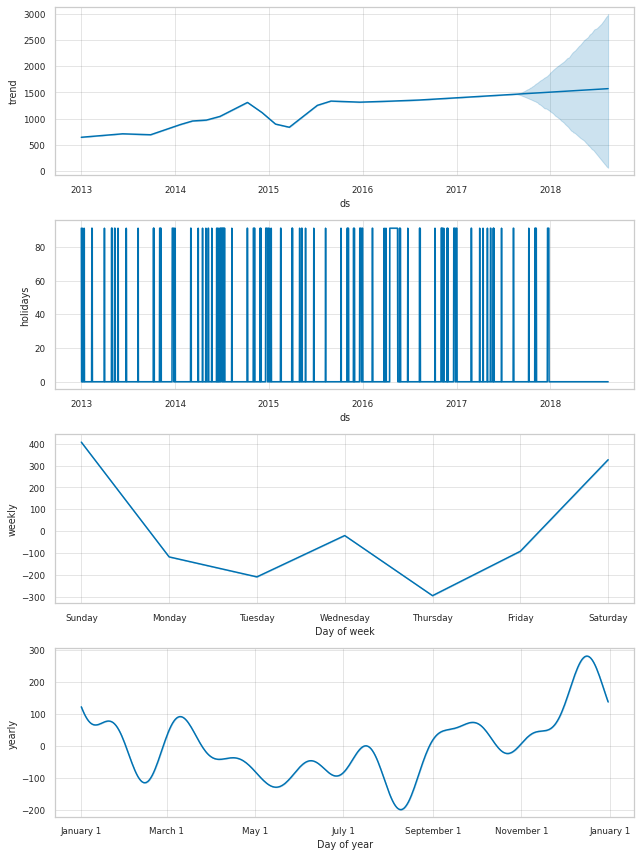

In [43]:
my_model.plot_components(forecast);

## Submit the predictions

In [56]:
submission_sample = pd.read_csv(path+'sample_submission.csv')

In [57]:
submission_sample.sales = preds[0].detach().cpu().numpy()
submission_sample.head(3)

,id,sales
0,3000888,36.412300
1,3000889,36.301899
2,3000890,49.293114


In [58]:
submission_sample.to_csv('submission.csv', index=False)